# AirBnB Data Analysis: Feature Engineering and Selection

In the current repository, I will analyze the [AirBnB dataset from the Basque Country / Euskadi](http://insideairbnb.com/get-the-data/). The [Basque Country](https://en.wikipedia.org/wiki/Basque_Country_(autonomous_community)) is the region from Spain I am from; after many years living in Germany, I moved back here in 2020. As a popular touristic target on the seaside, the analysis might be valuable for many visitors :-)

The first notebook `00_AirBnB_DataAnalysis_Initial_Tests.ipynb` has defined the main business questions, related to:

1. Most important features for price prediction (= target)
2. Difference in features between the two most important cities: Donostia-San Sebastian & Bilbao
3. Difference in features between cities with beach access and without
4. EXTRA: Predict review score from review texts

Now, the usual data science process continues:

1. Data cleaning and Preparation
2. Exploratory Data Analysis
3. **Feature Engineering**
4. **Feature Selection**
5. Modelling
6. Model Scoring & Inferences
7. Answering and presenting the Business Questions

The previous notebook `01_AirBnB_DataAnalysis_DataCleaning_EDA.ipynb` has performed the Data Cleaning and the Exploratory Data Analysis (EDA).

This notebook focuses on the next two steps: **Feature Engineering** and **Feature Selection**. Any transformations done in the EDA part of the previous notebook are re-done here. The file saved after the Data Cleaning is the input for the current notebook.

### Overview of Contents in the Current Notebook

1. Load Cleaned Dataset
2. Feature Engineering
    - 2.1 Transformations from the EDA
        - Get Feature Names and Types
        - Numerical Transformation (from EDA)
        - Categorical Transformation (from EDA)
        - Variables with Many Categories: Property Type
        - Recap: Which are the Missing Categorical Variables to Process?
    - 2.2 Extract Variables to Remain with
    - 2.3 Encoding of Other Categorical Variables
        - Date: categorical_cols_todo_date
        - Text Language: categorical_cols_todo_text
        - Special: categorical_cols_todo_special: 'bathrooms_text'
        - Special: categorical_cols_todo_special: 'calculated_host_listings_count_shared_rooms'
        - Special: categorical_cols_todo_special: 'amenities'
    - 2.4 Dummy Variables
        - Initial Inspection of all the Remaining Categoricals
        - One-Hot Encoding of Variables with Few Categories
        - Store Dataset
        - One-Hot Encoding of Variables with Many Categories
        - Store Final Dataset
    - 2.5 Polynomial Features
    - 2.6 Scaling
        - Train/Test Split
        - MinMaxScaler
    - 2.7 Persist Final Splits + Additional Data (scaler, mappings, etc.)
3. Feature Selection

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Lasso regression is the model used (L1 regularization: penaly to variable coefficients)
# SelectFromModel identifies the features that are important for the model
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import SelectFromModel

# To save the trained scaler class
import joblib

# Display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

## 1. Load Cleaned Dataset

In [89]:
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean.csv'
data = pd.read_csv(filename)

In [90]:
# Make a copy of the original
df = data.copy()

In [91]:
df.shape

(3931, 56)

In [92]:
df.head()

,id,name,listing_url,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,has_beach,review_scores_average,license_reported,host_location_nearby
0,132068,Great attic+terrace+parking. Beach views. ESS0...,https://www.airbnb.com/rooms/132068,"Amazing modern, clean & fully equiped flat of...",648938,Mikel,2011-05-31,within an hour,100%,100%,t,1,1,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Donostia-San Sebastian,Gipuzkoa,43.32520,-1.97209,Entire condo,Entire home/apt,4,1 bath,2.0,3.0,"[""Cooking basics"", ""Iron"", ""Host greets you"", ...",147.0,1,63,1,2,63,63,1.6,63.0,t,6,12,14,226,584,65,2,2011-06-04,2022-03-27,t,1,1,0,0,4.43,1,4.884286,0,0.0
1,134802,"Hab Luminosa,tranquila,baño privado",https://www.airbnb.com/rooms/134802,<b>The space</b><br />Habitación en piso compa...,661293,Roberto,2011-06-03,within an hour,100%,100%,f,2,2,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Bilbao,Bizkaia,43.24987,-2.93956,Private room in rental unit,Private room,1,1 private bath,1.0,1.0,"[""Dishwasher"", ""Laundromat nearby"", ""Drying ra...",39.0,3,120,3,3,1125,1125,3.0,1125.0,t,0,0,0,0,7,0,0,2012-07-16,2020-11-30,t,1,0,1,0,0.06,0,4.284286,0,0.0
2,142760,Apto San Juan de Gaztelugatxe,https://www.airbnb.com/rooms/142760,<b>The space</b><br />This charming new apartm...,693119,Maitane,2011-06-12,within an hour,100%,100%,t,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Busturia,Bizkaia,43.39062,-2.69470,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""Dishwasher"", ""Private patio or balcony"", ""Co...",119.0,6,730,6,6,730,730,6.0,730.0,t,29,59,89,332,43,4,0,2011-08-17,2021-08-29,f,1,1,0,0,0.33,1,4.704286,0,0.0
3,309802,Luxury w/terrace near the beach WIF,https://www.airbnb.com/rooms/309802,<b>The space</b><br />It is located in the pea...,1589633,Emy,2012-01-10,within a few hours,100%,97%,f,9,9,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,Donostia-San Sebastian,Gipuzkoa,43.31582,-2.00394,Entire rental unit,Entire home/apt,6,2 baths,2.0,5.0,"[""Dishwasher"", ""Backyard"", ""Cooking basics"", ""...",190.0,3,1125,3,3,1125,1125,3.0,1125.0,t,23,39,60,274,5,1,0,2014-05-06,2021-10-06,f,8,7,1,0,0.05,1,4.171429,0,0.0
4,309813,Near the beach with terrace WIFI,https://www.airbnb.com/rooms/309813,Luxury three bedrooms apartment located in a b...,1589633,Emy,2012-01-10,within a few hours,100%,97%,f,9,9,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,Donostia-San Sebastian,Gipuzkoa,43.31478,-1.98734,Entire rental unit,Entire home/apt,8,2 baths,3.0,5.0,"[""Dishwasher"", ""Cooking basics"", ""Air conditio...",180.0,31,124,31,31,124,124,31.0,124.0,t,28,45,75,300,12,0,0,2012-03-15,2018-06-02,f,8,7,1,0,0.10,1,4.675714,0,0.0


## 2. Feature Engineering

First the transformations defined during the EDA are applied. Then, new transformations are defined and applied.

### 2.1 Transformations from the EDA

#### Get Feature Names and Types

In [93]:
# Strings: some feature engineering is require
categorical_cols = list(df.select_dtypes(['object']).columns)
categorical_cols

['name',
 'listing_url',
 'description',
 'host_name',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'amenities',
 'has_availability',
 'first_review',
 'last_review',
 'instant_bookable']

In [94]:
# Almost all categorical variables need to be encoded
# but some can be directly dropped for modelling;
# manual selection of the ones to drop
categorical_cols_drop = ['listing_url', 'host_verifications']

In [95]:
# Floats: scaling is required probably
float_cols = list(df.select_dtypes(['float']).columns)
# Integers: scaling is required probably
int_cols = list(df.select_dtypes(['int']).columns)
numerical_cols = float_cols + int_cols
numerical_cols

['latitude',
 'longitude',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'reviews_per_month',
 'review_scores_average',
 'host_location_nearby',
 'id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'has_beach',
 'license_reported']

In [96]:
# Many numerical variables need to be transformed
# but some can be directly dropped for modelling;
# manual selection of the ones to drop
numerical_cols_drop = ['id', 'host_id', 'host_listings_count']

#### Price Correction: Price per Person

In [97]:
# Pricce correction does not work!
#df['price_unit'] = df['price'] / df['accommodates']

In [98]:
#df['price'] = df['price_unit']
#df.drop('price_unit',axis=1,inplace=True)

<AxesSubplot:>

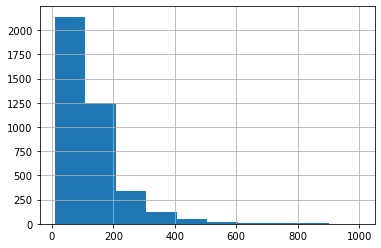

In [99]:
df['price'].hist()

#### Numerical Transformation (from EDA)

In [100]:
# From the EDA:
# Selection of candidates for a logarithmic-family transoformation.
# I choose the Yeo-Johnson transformation.
# The selection is done visually: the scatterplots variable-target are better when
# - larger spread
# - homogeneous density
# In the following, numerical variables are classified in subgroups
# after the visual inspection of the plots

# Numerical variables that are categorical
numerical_categorical = [
    'host_location_nearby',
    'has_beach',
    'license_reported'
]

# Numerical variables that will be binarized
numerical_binarized = ['calculated_host_listings_count_shared_rooms']

# Variables kept for transformation
numerical_transform = [
     'bedrooms',
     'beds',
     'price',
     #'price_unit',
     'minimum_nights_avg_ntm',
     'maximum_nights_avg_ntm',
     'reviews_per_month',
     'host_total_listings_count',
     'accommodates',
     'minimum_nights',
     'maximum_nights',
     'minimum_minimum_nights',
     'maximum_minimum_nights',
     'minimum_maximum_nights',
     'maximum_maximum_nights',
     'number_of_reviews',
     'number_of_reviews_ltm',
     'calculated_host_listings_count',
     'calculated_host_listings_count_entire_homes',
     'calculated_host_listings_count_private_rooms'
]

# Numerical variables left as they are (acceptable distribution)
numerical_other = [
    'latitude',
    'longitude',
    'review_scores_average',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews_l30d'
]

assert len(numerical_cols) == \
       len(numerical_categorical) + \
       len(numerical_binarized) + \
       len(numerical_transform) + \
       len(numerical_other) + len(numerical_cols_drop)

In [101]:
# Transform the numerical variables with Yeo-Johnson
# and store the parameters
numerical_transform_params = {}
for var in numerical_transform:
    if var == 'price' or var == 'price_unit':
        # Logarithmic transformation for target due to practical reasons
        df[var] = np.log(df[var])
    else:
        df[var], param = stats.yeojohnson(df[var])
        numerical_transform_params[var] = param

In [102]:
# Yeo-Johnso Transformation parameters
numerical_transform_params

{'bedrooms': -1.0402070267879564,
 'beds': -0.3059395762251768,
 'minimum_nights_avg_ntm': -1.031548319186732,
 'maximum_nights_avg_ntm': 1.292039894445428,
 'reviews_per_month': -0.8558329195885959,
 'host_total_listings_count': -0.4225374548348586,
 'accommodates': -0.12653943892207856,
 'minimum_nights': -1.247377597286875,
 'maximum_nights': 0.6802531557453844,
 'minimum_minimum_nights': -1.3449216078756545,
 'maximum_minimum_nights': -0.7245278768913469,
 'minimum_maximum_nights': 1.0508654684971468,
 'maximum_maximum_nights': 1.3370553390198696,
 'number_of_reviews': -0.031191513332035344,
 'number_of_reviews_ltm': -0.014480286216331528,
 'calculated_host_listings_count': -0.7715543804115744,
 'calculated_host_listings_count_entire_homes': -0.566660556641371,
 'calculated_host_listings_count_private_rooms': -1.5063543096526493}

In [103]:
# Numerical variables; note that columns to be dropped are not considered
numerical_cols = numerical_transform + numerical_other
print(f'Numer of numerical columns ready to be scaled: {len(numerical_cols)}')
numerical_cols

Numer of numerical columns ready to be scaled: 27


['bedrooms',
 'beds',
 'price',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'reviews_per_month',
 'host_total_listings_count',
 'accommodates',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'latitude',
 'longitude',
 'review_scores_average',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews_l30d']

#### Categorical Transformation (from EDA)

In [104]:
# Get a list of all categorical variables
categorical_cols = categorical_cols + numerical_categorical + numerical_binarized
categorical_cols

['name',
 'listing_url',
 'description',
 'host_name',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'amenities',
 'has_availability',
 'first_review',
 'last_review',
 'instant_bookable',
 'host_location_nearby',
 'has_beach',
 'license_reported',
 'calculated_host_listings_count_shared_rooms']

In [105]:
# Some categorcial variables are binary and their category values
# should be mapped from (t,f) -> (1,0)
binary_mappings = {'t': 1, 'f': 0}
binary_vars = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]
for var in binary_vars:
    df[var] = df[var].map(binary_mappings)

In [106]:
# Similarly, the categories of some variables are mapped
# for a an easier handling when they are converted to dummies
df['host_response_time'].replace({"within an hour":'hour',
                                  "within a few hours":'few_hours',
                                  "within a day":'day',
                                  "a few days or more":'few_days'},inplace=True)
df['room_type'].replace({"Entire home/apt":'home',
                         "Private room":'room_private',
                         "Shared room":'room_shared',
                         "Hotel room":'room_hotel'},inplace=True)

<AxesSubplot:>

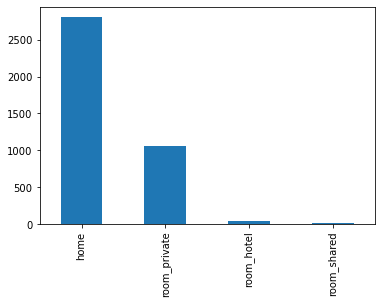

In [107]:
df['room_type'].value_counts().plot(kind="bar")

In [108]:
# These variables are percentages encoded as strings:
# host_response_rate, host_acceptance_rate
try:
    for col in ['host_response_rate', 'host_acceptance_rate']:
        df[col] = df[col].apply(lambda pcnt: float(pcnt.split("%")[0])/100.0)
except AttributeError as err:
    print("Values already converted!")

#### Variables with Many Categories: Property Type

The categories of `property_type` are many and with long names; for an easier handling as dummy variables, a bidirectional mapping between original category names and integers is defined. The integers are ordered, assigning lower values to property types which have lower median prices.

In [109]:
property_type_list = list(df.groupby('property_type')['price'].median().sort_values(ascending=True).index)
property_type_list

['Shared room in hostel',
 'Shared room in cottage',
 'Shared room in farm stay',
 'Shared room in bed and breakfast',
 'Campsite',
 'Shared room in rental unit',
 'Private room in floor',
 'Shared room in tent',
 'Private room in condo',
 'Private room in tiny home',
 'Private room in camper/rv',
 'Private room in townhouse',
 'Private room in rental unit',
 'Bus',
 'Private room in home',
 'Private room in casa particular',
 'Private room',
 'Private room in villa',
 'Private room in guesthouse',
 'Private room in serviced apartment',
 'Room in hostel',
 'Private room in chalet',
 'Private room in cottage',
 'Private room in guest suite',
 'Private room in bed and breakfast',
 'Private room in hostel',
 'Camper/RV',
 'Room in hotel',
 'Private room in loft',
 'Entire loft',
 'Entire vacation home',
 'Tiny home',
 'Room in boutique hotel',
 'Room in bed and breakfast',
 'Floor',
 'Entire guest suite',
 'Entire condo',
 'Entire guesthouse',
 'Casa particular',
 'Entire rental unit',
 '

In [110]:
# Create mapping dictionary
property_type_dict = {}
for i, property_type in enumerate(property_type_list):
    property_type_dict[property_type] = str(i+1)

In [111]:
# Map the values
df['property_type'] = df['property_type'].map(property_type_dict)

#### Recap: Which are the Missing Categorical Variables to Process?

In the following, the categorical variables are classified in groups for a better overview:

- `categorical_cols_todo_date`: extract days until today
- `categorical_cols_todo_text`: identify text language: English / Other
- `categorical_cols_todo_special`: one-by-one processing
- `categorical_cols_todo_dummify`: ready to convert into dummy variables
- `categorical_cols_ready`: nothing to be done

The sum of all of them yield the set of features that need to be taken from the group of categorical variables

In [1328]:
categorical_cols_drop = [
    'listing_url',
    'host_verifications',
    'host_name',
]

categorical_cols_todo = [
    'name',
    'description',
    'host_since',
    'host_response_time',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'property_type',
    'room_type',
    'bathrooms_text',
    'amenities',
    'first_review',
    'last_review',
    'calculated_host_listings_count_shared_rooms'
]

categorical_cols_todo_text = [
    'name',
    'description'
]

categorical_cols_todo_date = [
    'host_since',
    'first_review',
    'last_review',
]

categorical_cols_todo_dummify = [
    'host_response_time',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'property_type',
    'room_type',
]

categorical_cols_todo_special = [
    'bathrooms_text', # extract features
    'amenities', # extract categories in set
    'calculated_host_listings_count_shared_rooms' # binarize
]

assert len(categorical_cols_todo) == \
       len(categorical_cols_todo_text) + \
       len(categorical_cols_todo_date) + \
       len(categorical_cols_todo_dummify) + \
       len(categorical_cols_todo_special)

categorical_cols_ready = [
    'host_response_rate',
    'host_acceptance_rate',
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable',
    'host_location_nearby',
    'has_beach',
    'license_reported',
]

In [1329]:
df[categorical_cols_ready].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_rate      3931 non-null   float64
 1   host_acceptance_rate    3931 non-null   float64
 2   host_is_superhost       3931 non-null   int64  
 3   host_has_profile_pic    3931 non-null   int64  
 4   host_identity_verified  3931 non-null   int64  
 5   has_availability        3931 non-null   int64  
 6   instant_bookable        3931 non-null   int64  
 7   host_location_nearby    3931 non-null   float64
 8   has_beach               3931 non-null   int64  
 9   license_reported        3931 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 307.2 KB


### 2.2 Extract Variables to Remain with

In [1330]:
# Features
X = df[['id']+numerical_cols+categorical_cols_ready+categorical_cols_todo].copy()
X.drop('price',axis=1,inplace=True)
# Target
y = df['price'].copy()

In [1331]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3931 non-null   int64  
 1   bedrooms                                      3931 non-null   float64
 2   beds                                          3931 non-null   float64
 3   minimum_nights_avg_ntm                        3931 non-null   float64
 4   maximum_nights_avg_ntm                        3931 non-null   float64
 5   reviews_per_month                             3931 non-null   float64
 6   host_total_listings_count                     3931 non-null   float64
 7   accommodates                                  3931 non-null   float64
 8   minimum_nights                                3931 non-null   float64
 9   maximum_nights                                3931 non-null   f

### 2.3 Encoding of Other Categorical Variables

#### Date: `categorical_cols_todo_date`

In [1332]:
categorical_cols_todo_date

['host_since', 'first_review', 'last_review']

In [1333]:
X[categorical_cols_todo_date].head()

,host_since,first_review,last_review
0,2011-05-31,2011-06-04,2022-03-27
1,2011-06-03,2012-07-16,2020-11-30
2,2011-06-12,2011-08-17,2021-08-29
3,2012-01-10,2014-05-06,2021-10-06
4,2012-01-10,2012-03-15,2018-06-02


In [1334]:
# We convert the dates to days since today
today = datetime.datetime(2022,6,17)
for col in categorical_cols_todo_date:
    X[col] = pd.to_datetime(X[col], format='%Y-%m-%d')
    X[col] = X[col].apply(lambda col: int((today-col).days))

In [1335]:
X[categorical_cols_todo_date].head()

,host_since,first_review,last_review
0,4035,4031,82
1,4032,3623,564
2,4023,3957,292
3,3811,2964,254
4,3811,3746,1476


#### Text Language: `categorical_cols_todo_text`

We will extract the language of the text.

In [1336]:
categorical_cols_todo_text

['name', 'description']

In [1337]:
X['name']

0       Great attic+terrace+parking. Beach views. ESS0...
1                     Hab Luminosa,tranquila,baño privado
2                           Apto San Juan de Gaztelugatxe
3                     Luxury w/terrace near the beach WIF
4                        Near the beach with terrace WIFI
                              ...                        
3926     Apartment Virgen del Valle-(Breakfast included).
3927                                      Chambre Tantana
3928                                  Appartement Urrugne
3929                    RiojaValley: Apartamento TRUJALES
3930           Duplex céntrico en primera línea de playa.
Name: name, Length: 3931, dtype: object

In [1338]:
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language

# Now, we need to create a factory for the LanguageDetector added to the pipe
@Language.factory('language_detector')
def language_detector(nlp, name):
    return LanguageDetector()

In [1339]:
# We load our English model
nlp = spacy.load('en_core_web_sm')

In [1340]:
#nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
nlp.add_pipe('language_detector', last=True)

In [1341]:
# Small test with the most expected languages
text1 = 'This is an english text.'
text2 = 'Este es un texto en castellano.'
text3 = 'Dieser Text ist auf Deutsch.'
text4 = 'Le Text est en Francais.'
texts = [text1, text2, text3, text4]
for text in texts:
    doc = nlp(text)
    # Document level language detection.
    print(doc._.language)

{'language': 'en', 'score': 0.9999966547705994}
{'language': 'es', 'score': 0.9999962879224319}
{'language': 'de', 'score': 0.9999979544182089}
{'language': 'fr', 'score': 0.9999980522837456}


In [1342]:
# Define language detection function to apply
def detect_language(text):
    doc = nlp(text)
    return doc._.language['language']

In [1343]:
for col in categorical_cols_todo_text:
    X[col+'_language'] = X[col].apply(detect_language)

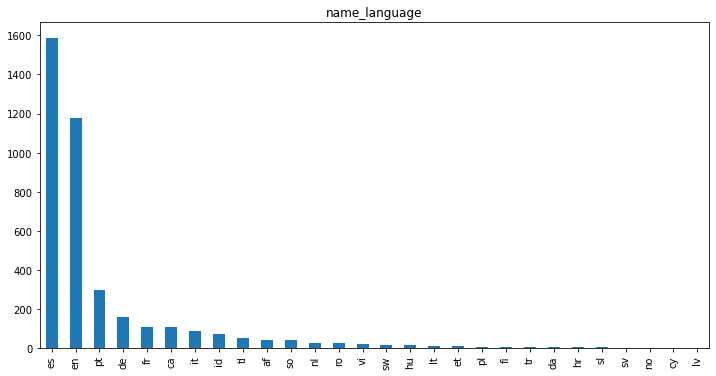

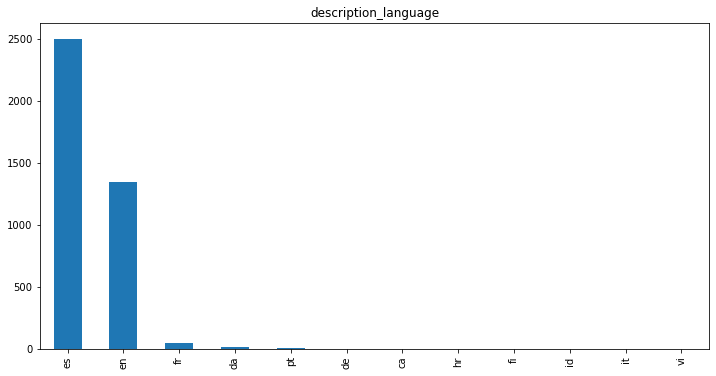

In [1344]:
# A visualization of the languages
for col in categorical_cols_todo_text:
    plt.figure(figsize=(12,6))
    X[col+'_language'].value_counts().plot(kind='bar')
    plt.title(col+'_language')
    plt.show()

Decision: we drop `name_language` and compress `description_language` to `['en', 'es', 'fr', 'other']`. Reasons:

- Maybe it is better to focus on one text field instead of two.
- The majority of languages are English and Spanish; however, French visitors are very common in the region.

In [1345]:
# Drop name-related fiels
X.drop(['name', 'name_language'],axis=1,inplace=True)

In [1346]:
# Quick check
'name_language' in X.columns

False

In [1347]:
# Which are all the different languages that were detected?
X['description_language'].unique()

array(['en', 'es', 'de', 'fr', 'pt', 'da', 'hr', 'ca', 'fi', 'id', 'it',
       'vi'], dtype=object)

In [1348]:
# Manually group the minority languages together
X['description_language'].replace({'de':'other',
                                   'pt':'other',
                                   'da':'other',
                                   'ca':'other',
                                   'hr':'other',
                                   'it':'other',
                                   'fi':'other',
                                   'sv':'other',
                                   'tl':'other',
                                   'id':'other',
                                   'cy':'other',
                                   'no':'other',
                                   'vi':'other'},inplace=True)

In [1349]:
X['description_language'].unique()

array(['en', 'es', 'other', 'fr'], dtype=object)

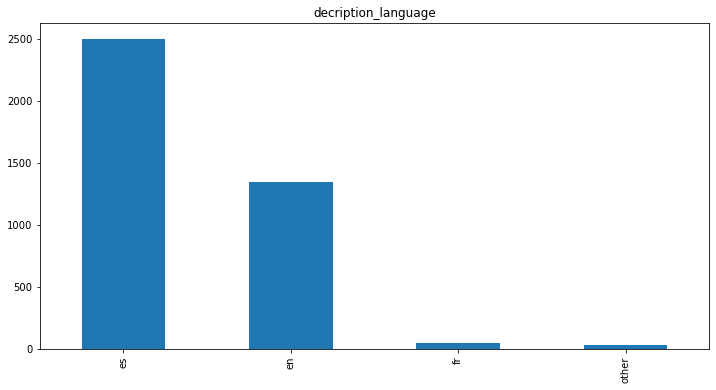

In [1350]:
plt.figure(figsize=(12,6))
X['description_language'].value_counts().plot(kind='bar')
plt.title('decription_language')
plt.show()

In [1351]:
# Check if we have created any NaN values
X['description_language'].isnull().sum()

0

In [1352]:
# Add the new generated column to the list to be dummified
categorical_cols_todo_dummify = list(categorical_cols_todo_dummify) + ['description_language']
categorical_cols_todo_dummify = set(categorical_cols_todo_dummify)
categorical_cols_todo_dummify = list(categorical_cols_todo_dummify)
categorical_cols_todo_dummify

['neighbourhood_group_cleansed',
 'property_type',
 'host_response_time',
 'neighbourhood_cleansed',
 'description_language',
 'room_type']

In [1353]:
# Remove the description text
try:
    X.drop('description',axis=1,inplace=True)
except KeyError as err:
    print("Column already removed!")

#### Special: `categorical_cols_todo_special`: `'bathrooms_text'`

In [1354]:
categorical_cols_todo_special

['bathrooms_text', 'amenities', 'calculated_host_listings_count_shared_rooms']

In [1355]:
# Observation: all texts contain a number + bath and then optionally the word shared/private
# We use that to extract:
# - bathrooms_number
# - bathrooms_shared
# - bathrooms_private
list(X['bathrooms_text'].unique())

['1 bath',
 '1 private bath',
 '2 baths',
 '3.5 baths',
 '5 baths',
 '2 shared baths',
 '3 baths',
 'Shared half-bath',
 '2.5 baths',
 '1 shared bath',
 '1.5 baths',
 '1.5 shared baths',
 'Half-bath',
 '3 shared baths',
 '0 shared baths',
 '4.5 baths',
 '8 baths',
 '4 baths',
 '0 baths',
 '7.5 shared baths',
 '6.5 baths',
 '7 shared baths',
 '5 shared baths',
 '6 baths',
 '3.5 shared baths',
 '4.5 shared baths',
 '2.5 shared baths',
 '9.5 baths',
 '5.5 baths',
 '6 shared baths',
 '4 shared baths',
 '8 shared baths',
 '5.5 shared baths',
 '7.5 baths',
 '8.5 baths']

In [1356]:
# Map the exception categories: 'Shared half-bath', 'Half-bath'
X['bathrooms_text'].replace({'Shared half-bath':'0.5 shared baths',
                             'Half-bath':'0.5 shared baths'},inplace=True)

In [1357]:
list(X['bathrooms_text'].unique())

['1 bath',
 '1 private bath',
 '2 baths',
 '3.5 baths',
 '5 baths',
 '2 shared baths',
 '3 baths',
 '0.5 shared baths',
 '2.5 baths',
 '1 shared bath',
 '1.5 baths',
 '1.5 shared baths',
 '3 shared baths',
 '0 shared baths',
 '4.5 baths',
 '8 baths',
 '4 baths',
 '0 baths',
 '7.5 shared baths',
 '6.5 baths',
 '7 shared baths',
 '5 shared baths',
 '6 baths',
 '3.5 shared baths',
 '4.5 shared baths',
 '2.5 shared baths',
 '9.5 baths',
 '5.5 baths',
 '6 shared baths',
 '4 shared baths',
 '8 shared baths',
 '5.5 shared baths',
 '7.5 baths',
 '8.5 baths']

In [1358]:
X['bathrooms_number'] = X['bathrooms_text'].apply(lambda text: float(text.split(' ')[0]))

<AxesSubplot:ylabel='Frequency'>

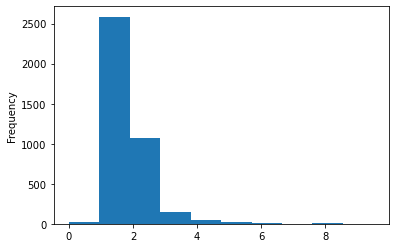

In [1359]:
X['bathrooms_number'].plot(kind="hist")

In [1360]:
X['bathrooms_number'].isnull().sum()

0

In [1361]:
'private' in '6 shared baths'

False

In [1362]:
X['bathrooms_private'] = X['bathrooms_text'].apply(lambda text: 1 if 'private' in text else 0)

In [1363]:
X['bathrooms_shared'] = X['bathrooms_text'].apply(lambda text: 1 if 'shared' in text else 0)

In [1364]:
X['bathrooms_private'].isnull().sum()

0

In [1365]:
X['bathrooms_shared'].isnull().sum()

0

<AxesSubplot:>

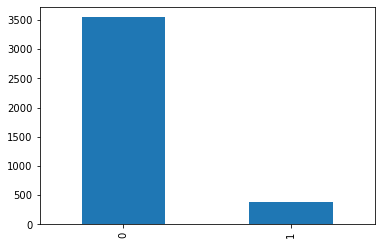

In [1366]:
X['bathrooms_private'].value_counts().plot(kind="bar")

<AxesSubplot:>

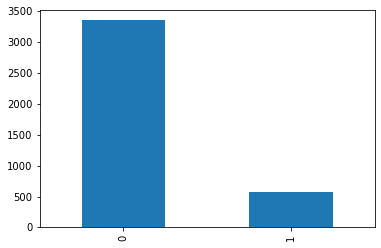

In [1367]:
X['bathrooms_shared'].value_counts().plot(kind="bar")

In [1368]:
# Remove the bathrooms text
try:
    X.drop('bathrooms_text',axis=1,inplace=True)
except KeyError as err:
    print("Column already removed!")

#### Special: `categorical_cols_todo_special`: `'calculated_host_listings_count_shared_rooms'`

In [1369]:
X['calculated_host_listings_count_shared_rooms'].value_counts()

0    3894
9      21
2       6
1       5
4       5
Name: calculated_host_listings_count_shared_rooms, dtype: int64

In [1370]:
X['calculated_host_has_shared_rooms'] = X['calculated_host_listings_count_shared_rooms']

In [1371]:
# Manually group the minority languages together
X['calculated_host_has_shared_rooms'].replace({9:1,
                                               2:1,
                                               1:1,
                                               4:1},inplace=True)

In [1372]:
X['calculated_host_has_shared_rooms'].value_counts()

0    3894
1      37
Name: calculated_host_has_shared_rooms, dtype: int64

#### Special: `categorical_cols_todo_special`: `'amenities'`

We need to create a set of all amenities that exist. Then, each amenity will be a dummy variable.

In [1373]:
X['amenities']

0       ["Cooking basics", "Iron", "Host greets you", ...
1       ["Dishwasher", "Laundromat nearby", "Drying ra...
2       ["Dishwasher", "Private patio or balcony", "Co...
3       ["Dishwasher", "Backyard", "Cooking basics", "...
4       ["Dishwasher", "Cooking basics", "Air conditio...
                              ...                        
3926    ["Dishwasher", "Freezer", "Pocket wifi", "Cook...
3927    ["Iron", "Patio or balcony", "Long term stays ...
3928    ["Drying rack for clothing", "Freezer", "Cloth...
3929    ["Smart lock", "Private patio or balcony", "Ir...
3930    ["Indoor fireplace", "Dishwasher", "Cooking ba...
Name: amenities, Length: 3931, dtype: object

In [1374]:
index = 0
amenity_types = X['amenities'].iloc[index].split(",")
for amenity in amenity_types:
    print(amenity.split('"')[1])

Cooking basics
Iron
Host greets you
Patio or balcony
Long term stays allowed
Shampoo
Coffee maker
Luggage dropoff allowed
Kitchen
Dedicated workspace
Wifi
Heating
Crib
Elevator
TV
Essentials
Refrigerator
First aid kit
Dishes and silverware
Free parking on premises
Washer
Stove
Hangers
Hot water
Children\u2019s books and toys
Hair dryer
Microwave
Oven


In [1375]:
amenities_set = set()
for i in range(X.shape[0]):
    amenity_types = X['amenities'].iloc[i].split(",")
    for amenity in amenity_types:
        try:
            amenity_item = amenity.split('"')
            if len(amenity_item) == 1:
                amenities_set.add(amenity_item[0][1:])
            else:
                amenities_set.add(amenity_item[1])                
        except IndexError as err:
            print("Unusual amenity encoding")

In [1376]:
# There are almost 700 different amenity strings
len(amenities_set)

636

In [1377]:
# There are almost 700 different amenity strings
# but many of them are related.
# We can compress the list by removing brands and repeated items.
amenities_set

{'',
 '- body soap',
 '2-5 years old',
 '20\\',
 '21\\',
 '24\\',
 '27\\',
 '28\\',
 '30\\',
 '31\\',
 '32\\',
 '34\\',
 '35\\',
 '37\\',
 '39\\',
 '40\\',
 '42\\',
 '43\\',
 '45\\',
 '46\\',
 '47\\',
 '48\\',
 '49\\',
 '5-10 years old',
 '50\\',
 '52\\',
 '54\\',
 '55\\',
 '60\\',
 '65\\',
 '75\\',
 '77\\',
 '80\\',
 'AEG refrigerator',
 'AEG stainless steel oven',
 'AESOP body soap',
 'Acero inox refrigerator',
 'Air conditioning',
 'Altavoz - Blouutood Bluetooth sound system',
 'Amazon Prime Video',
 'Amenities para la primera noche. body soap',
 'Amigo de la Naturaleza body soap',
 'Amigo de la Naturaleza conditioner',
 'Amigo de la Naturaleza shampoo',
 'Aminities body soap',
 'Apple TV',
 'Axe body soap',
 'BBQ grill',
 'BOSCH induction stove',
 'BOSCH refrigerator',
 'Baby bath',
 'Baby monitor',
 'Baby safety gates',
 'Babysitter recommendations',
 'Backyard',
 'Baking sheet',
 'Balay  electric stove',
 'Balay  oven',
 'Balay (compartido)  refrigerator',
 'Balay electric stove'

In [1378]:
# There are almost 700 different amenity strings
# but many of them are related.
# We can compress the list by removing brands and repeated items.
# Manual selection
amenities_list = [
 'body soap',
 'refrigerator',
 'stainless steel oven',
 'Air conditioning',
 'sound system',
 'Amazon Prime Video',
 'conditioner',
 'shampoo',
 'Apple TV',
 'BBQ grill',
 'induction stove',
 'Baby bath',
 'Baby monitor',
 'Baby safety gates',
 'Babysitter recommendations',
 'Backyard',
 'Baking sheet',
 'shared refrigerator',
 'oven',
 'stainless steel electric stove',
 'Barbecue utensils',
 'Bathroom essentials',
 'Bathtub',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Bikes',
 'Board games',
 'Boat slip',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Cable TV',
 'Carbon monoxide alarm',
 'Ceiling fan',
 'Central air conditioning',
 'Central heating',
 'Changing table',
 'books and toys',
 'Chromecast',
 'Cleaning before checkout',
 'Cleaning products',
 'Clothing storage',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Dedicated workspace',
 'Dining table',
 'Dishes and silverware',
 'Dishwasher',
 'Dryer',
 'Drying rack for clothing',
 'EV charger',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Fast wifi',
 'Fenced garden or backyard',
 'Fire extinguisher',
 'Fire pit',
 'Fireplace guards',
 'First aid kit',
 'Free carport on premises',
 'Free driveway parking on premises',
 'Free dryer',
 'Free parking garage on premises',
 'Free parking on premises',
 'Free residential garage on premises',
 'Free street parking',
 'Free washer',
 'Freezer',
 'Full kitchen',
 'Game console',
 'Gas stove',
 'Gym',
 'Gym nearby',
 'HBO Max',
 'HDTV',
 'Netflix',
 'Hair dryer',
 'Hangers',
 'Heating',
 'High chair',
 'Host greets you',
 'Hot tub',
 'Hot water',
 'Hot water kettle',
 'Indoor fireplace',
 'coffee machine',
 'Keypad',
 'Kitchen',
 'Lake access',
 'Laundromat nearby',
 'Lock on bedroom door',
 'Lockbox',
 'Long term stays allowed',
 'Luggage dropoff allowed',
 'Microwave',
 'Mini fridge',
 'Mosquito net',
 'Nespresso machine',
 'Outdoor dining area',
 'Outdoor furniture',
 'Outdoor infinity pool',
 'Outdoor shower',
 'Outlet covers',
 'Paid dryer',
 'Paid parking garage off premises',
 'Paid parking garage on premises',
 'Paid parking lot off premises',
 'Paid parking lot on premises',
 'Paid parking off premises',
 'Paid parking on premises',
 'Paid street parking off premises',
 'Paid washer',
 'Patio or balcony',
 'Pets allowed',
 'Piano',
 'Ping pong table',
 'Pool',
 'Pool table',
 'Portable air conditioning',
 'Portable fans',
 'Portable heater',
 'Private entrance',
 'Private fenced garden or backyard',
 'Private garden or backyard',
 'Private gym',
 'Private gym nearby',
 'Private heated pool',
 'Private hot tub',
 'Private outdoor heated saltwater pool',
 'Private outdoor infinity pool',
 'Private outdoor pool',
 'Private outdoor saltwater pool',
 'Private patio or balcony',
 'Private pool',
 'Private sauna',
 'Rice maker',
 'Room-darkening shades',
 'Safe',
 'Sauna',
 'Security cameras on property',
 'Self check-in',
 'Shared fenced garden or backyard',
 'Shared garden or backyard',
 'Shared gym in building',
 'Shared gym nearby',
 'Shared hot tub',
 'Shared indoor heated olympic-sized pool',
 'Shared indoor heated saltwater pool',
 'Shared outdoor lap pool',
 'Shared outdoor pool',
 'Shared outdoor rooftop pool',
 'Shared patio or balcony',
 'Shared pool',
 'Shared sauna',
 'Shower gel',
 'Single level home',
 'Ski-in/Ski-out',
 'Smart lock',
 'Smoke alarm',
 'TV',
 'premium cable',
 'standard cable',
 'Table corner guards',
 'Toaster',
 'Trash compactor',
 'Washer',
 'Waterfront',
 'Window AC unit',
 'Window guards',
 'Wine glasses',
 'desk',
 'dresser',
 'monitor',
 'office chair',
 'table',
 'walk-in closet',
 'wardrobe',
]

In [1379]:
len(amenities_list)

181

In [1380]:
amenities_compressed = set()
for el in amenities_list:
    #amenities_compressed.add(el.lower().replace(' ','_'))
    amenities_compressed.add(el.lower())

In [1381]:
amenities_compressed = list(amenities_compressed)
print(len(amenities_compressed))
amenities_compressed

181


['clothing storage',
 'mini fridge',
 'hdtv',
 'shared refrigerator',
 'private gym',
 'bedroom comforts',
 'walk-in closet',
 'dryer',
 'trash compactor',
 'high chair',
 'paid dryer',
 'baby monitor',
 'piano',
 'lock on bedroom door',
 'private garden or backyard',
 'patio or balcony',
 'bathtub',
 'dishes and silverware',
 'central air conditioning',
 'central heating',
 'baby safety gates',
 'full kitchen',
 'oven',
 'private sauna',
 'stainless steel electric stove',
 'drying rack for clothing',
 'cable tv',
 'private outdoor infinity pool',
 'shared outdoor lap pool',
 'private outdoor saltwater pool',
 'changing table',
 'fast wifi',
 'beachfront',
 'crib',
 'private outdoor pool',
 'portable heater',
 'hair dryer',
 'fire pit',
 'shared fenced garden or backyard',
 'office chair',
 'paid street parking off premises',
 'private entrance',
 'paid parking garage off premises',
 'bed linens',
 'gas stove',
 'baking sheet',
 'ethernet connection',
 'cooking basics',
 'breakfast',
 

Encoding these as dumies, adds 181 columns to the feature matrix. Before doing that, the categorical variables with less levels/categories are one-hot-encoded and a snapshot of the processed dataset is saved.

### 2.4 Dummy Variables

First, we will dummify the remaining categorical variables that have few categories; then, after saving an intermmediate snapshot, the rest.

#### Initial Inspection of all the Remaining Categoricals

In [1382]:
categorical_cols_todo_dummify

['neighbourhood_group_cleansed',
 'property_type',
 'host_response_time',
 'neighbourhood_cleansed',
 'description_language',
 'room_type']

In [1383]:
list(X.select_dtypes(['object']).columns)

['host_response_time',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'amenities',
 'description_language']

In [1384]:
many_dummies = [
'neighbourhood_cleansed',
'property_type',
'ammenities']

few_dummies = [
 'neighbourhood_group_cleansed',
 'host_response_time',
 'description_language',
 'room_type']

In [1385]:
for col in few_dummies:
    print(f'{col}: {X[col].unique()}\n')

neighbourhood_group_cleansed: ['Gipuzkoa' 'Bizkaia' 'Araba']

host_response_time: ['hour' 'few_hours' 'day' 'few_days']

description_language: ['en' 'es' 'other' 'fr']

room_type: ['home' 'room_private' 'room_shared' 'room_hotel']



In [1386]:
print(f'neighbourhood_cleansed: {X["neighbourhood_cleansed"].unique()}\n')

neighbourhood_cleansed: ['Donostia-San Sebastian' 'Bilbao' 'Busturia' 'Plentzia' 'Oiartzun'
 'Gorliz' 'Ibarrangelu' 'Durango' 'Deba' 'Sopelana' 'Amurrio' 'Lekeitio'
 'Pasaia' 'Hondarribia' 'Portugalete' 'Vitoria-Gasteiz' 'Mutriku'
 'Karrantza Harana' 'Gernika-Lumo' 'Getxo' 'Orio' 'Getaria' 'Errenteria'
 'Zarautz' 'Ea' 'Urnieta' 'Zuia' 'Azpeitia' 'Bakio' 'Bermeo' 'Barakaldo'
 'Sopuerta' 'Lanciego' 'Zumaia' 'Irun' 'Labastida' 'Mundaka' 'Segura'
 'Asteasu' 'Valdegovia' 'Laguardia' 'Mungia' 'Aia' 'Lasarte-Oria'
 'Mendexa' 'Leioa' 'Hernani' 'Eibar' 'Samaniego' 'Astigarraga'
 'Urduna-Orduna' 'Markina-Xemein' 'Azkoitia' 'Gautegiz Arteaga'
 'Santurtzi' 'Elciego' 'Ortuella' 'Sestao' 'Derio']



In [1387]:
# Small fix to avoid having white spaces
X['neighbourhood_cleansed'].replace({'Donostia-San Sebastian':'Donostia-San_Sebastian'},inplace=True)

#### One-Hot Encoding of Variables with Few Categories

Note that all categories are exclusive; however, the first category (the most common) is not dropped, to track more clearly its effect.

In [1388]:
# Note: first category is NOT dropped:
# 'neighbourhood_group_cleansed': Gipuzkoa
# 'host_response_time': hour
# 'description_language': en
# 'room_type': home

few_dummies = [
 'neighbourhood_group_cleansed',
 'host_response_time',
 'description_language',
 'room_type']
try:
    for col in few_dummies:
        X = pd.concat([X.drop(col, axis=1),
                       pd.get_dummies(X[col],
                                      prefix=col, 
                                      prefix_sep='_',
                                      drop_first=False,
                                      dummy_na=False)],
                       axis=1)
except KeyError as err:
    print("Columns already dummified!")

In [1389]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 63 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3931 non-null   int64  
 1   bedrooms                                      3931 non-null   float64
 2   beds                                          3931 non-null   float64
 3   minimum_nights_avg_ntm                        3931 non-null   float64
 4   maximum_nights_avg_ntm                        3931 non-null   float64
 5   reviews_per_month                             3931 non-null   float64
 6   host_total_listings_count                     3931 non-null   float64
 7   accommodates                                  3931 non-null   float64
 8   minimum_nights                                3931 non-null   float64
 9   maximum_nights                                3931 non-null   f

#### Store Dataset

In [1390]:
data = pd.concat([X,y],axis=1)
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean_processed.csv'
data.to_csv(filename, index=False, header=True)

In [1391]:
data.head()

,id,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_location_nearby,has_beach,license_reported,host_since,neighbourhood_cleansed,property_type,amenities,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bathrooms_private,bathrooms_shared,calculated_host_has_shared_rooms,neighbourhood_group_cleansed_Araba,neighbourhood_group_cleansed_Bizkaia,neighbourhood_group_cleansed_Gipuzkoa,host_response_time_day,host_response_time_few_days,host_response_time_few_hours,host_response_time_hour,description_language_en,description_language_es,description_language_fr,description_language_other,room_type_home,room_type_room_hotel,room_type_room_private,room_type_room_shared,price
0,132068,0.654745,1.129818,0.607636,166.096950,0.893824,0.600867,1.456132,0.464003,23.417905,0.450825,0.757540,74.298150,193.704437,5.778404,4.065099,0.536857,0.573222,-0.000000,43.32520,-1.97209,4.884286,6,12,14,226,2,1.0,1.00,1,1,1,1,1,0.0,1,0,4035,Donostia-San_Sebastian,37,"[""Cooking basics"", ""Iron"", ""Host greets you"", ...",4031,82,0,1.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,4.990433
1,134802,0.493885,0.624583,0.737433,6782.407195,0.056840,0.878893,0.663619,0.659447,36.914005,0.628304,0.874692,1530.873565,8992.701886,2.013439,-0.000000,0.536857,-0.000000,0.430178,43.24987,-2.93956,4.284286,0,0,0,0,0,1.0,1.00,0,1,1,1,1,0.0,0,0,4032,Bilbao,13,"[""Dishwasher"", ""Laundromat nearby"", ""Drying ra...",3623,564,0,1.0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,3.663562
2,142760,0.493885,0.624583,0.839175,3880.904706,0.253044,0.878893,1.025668,0.730912,129.002244,0.689249,1.043195,971.895876,5046.639460,3.569391,1.590829,0.536857,0.573222,-0.000000,43.39062,-2.69470,4.704286,29,59,89,332,0,1.0,1.00,1,1,1,1,0,0.0,1,0,4023,Busturia,40,"[""Dishwasher"", ""Private patio or balcony"", ""Co...",3957,292,0,1.0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,4.779123
3,309802,0.654745,1.379336,0.737433,6782.407195,0.047786,1.472119,1.724846,0.659447,173.574292,0.628304,0.874692,1530.873565,8992.701886,1.742611,0.689680,1.058191,1.221560,0.430178,43.31582,-2.00394,4.171429,23,39,60,274,0,1.0,0.97,0,1,0,1,0,0.0,1,0,3811,Donostia-San_Sebastian,40,"[""Dishwasher"", ""Backyard"", ""Cooking basics"", ""...",2964,254,0,2.0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,5.247024
4,309813,0.734040,1.379336,0.942260,395.518179,0.091527,1.472119,1.918217,0.791052,37.772678,0.736507,1.268157,151.111280,475.173611,2.465028,-0.000000,1.058191,1.221560,0.430178,43.31478,-1.98734,4.675714,28,45,75,300,0,1.0,0.97,0,1,0,1,0,0.0,1,0,3811,Donostia-San_Sebastian,40,"[""Dishwasher"", ""Cooking basics"", ""Air conditio...",3746,1476,0,2.0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,5.192957


In [1392]:
data = pd.read_csv(filename)

In [1393]:
y = data['price']
X = data.drop('price',axis=1)

#### One-Hot Encoding of Variables with Many Categories

First, the easiest ones are processed.

In [1394]:
many_dummies = [
'neighbourhood_cleansed',
'property_type',
'ammenities']

try:
    for col in ['neighbourhood_cleansed', 'property_type']:
        X = pd.concat([X.drop(col, axis=1),
                       pd.get_dummies(X[col],
                                      prefix=col, 
                                      prefix_sep='_',
                                      drop_first=False,
                                      dummy_na=False)],
                       axis=1)
except KeyError as err:
    print("Columns already dummified!")

In [1395]:
X.head()

,id,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_location_nearby,has_beach,license_reported,host_since,amenities,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bathrooms_private,bathrooms_shared,calculated_host_has_shared_rooms,neighbourhood_group_cleansed_Araba,neighbourhood_group_cleansed_Bizkaia,neighbourhood_group_cleansed_Gipuzkoa,host_response_time_day,host_response_time_few_days,host_response_time_few_hours,host_response_time_hour,description_language_en,description_language_es,description_language_fr,description_language_other,room_type_home,room_type_room_hotel,room_type_room_private,room_type_room_shared,neighbourhood_cleansed_Aia,neighbourhood_cleansed_Amurrio,neighbourhood_cleansed_Asteasu,neighbourhood_cleansed_Astigarraga,neighbourhood_cleansed_Azkoitia,neighbourhood_cleansed_Azpeitia,neighbourhood_cleansed_Bakio,neighbourhood_cleansed_Barakaldo,neighbourhood_cleansed_Bermeo,neighbourhood_cleansed_Bilbao,neighbourhood_cleansed_Busturia,neighbourhood_cleansed_Deba,neighbourhood_cleansed_Derio,neighbourhood_cleansed_Donostia-San_Sebastian,neighbourhood_cleansed_Durango,neighbourhood_cleansed_Ea,neighbourhood_cleansed_Eibar,neighbourhood_cleansed_Elciego,neighbourhood_cleansed_Errenteria,neighbourhood_cleansed_Gautegiz Arteaga,neighbourhood_cleansed_Gernika-Lumo,neighbourhood_cleansed_Getaria,neighbourhood_cleansed_Getxo,neighbourhood_cleansed_Gorliz,neighbourhood_cleansed_Hernani,neighbourhood_cleansed_Hondarribia,neighbourhood_cleansed_Ibarrangelu,neighbourhood_cleansed_Irun,neighbourhood_cleansed_Karrantza Harana,neighbourhood_cleansed_Labastida,neighbourhood_cleansed_Laguardia,neighbourhood_cleansed_Lanciego,neighbourhood_cleansed_Lasarte-Oria,neighbourhood_cleansed_Leioa,neighbourhood_cleansed_Lekeitio,neighbourhood_cleansed_Markina-Xemein,neighbourhood_cleansed_Mendexa,neighbourhood_cleansed_Mundaka,neighbourhood_cleansed_Mungia,neighbourhood_cleansed_Mutriku,neighbourhood_cleansed_Oiartzun,neighbourhood_cleansed_Orio,neighbourhood_cleansed_Ortuella,neighbourhood_cleansed_Pasaia,neighbourhood_cleansed_Plentzia,neighbourhood_cleansed_Portugalete,neighbourhood_cleansed_Samaniego,neighbourhood_cleansed_Santurtzi,neighbourhood_cleansed_Segura,neighbourhood_cleansed_Sestao,neighbourhood_cleansed_Sopelana,neighbourhood_cleansed_Sopuerta,neighbourhood_cleansed_Urduna-Orduna,neighbourhood_cleansed_Urnieta,neighbourhood_cleansed_Valdegovia,neighbourhood_cleansed_Vitoria-Gasteiz,neighbourhood_cleansed_Zarautz,neighbourhood_cleansed_Zuia,neighbourhood_cleansed_Zumaia,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16,property_type_17,property_type_18,property_type_19,property_type_20,property_type_21,property_type_22,property_type_23,property_type_24,property_type_25,property_type_26,property_type_27,property_type_28,property_type_29,property_type_30,property_type_31,property_type_32,property_type_33,property_type_34,property_type_35,property_type_36,property_type_37,property_type_38,property_type_39,property_type_40,property_type_41,property_type_42,property_type_43,property_type_44,property_type_45,property_type_46,property_type_47,property_type_48,property_typ

Finally, the amenities need to be processed. We will create a column for each of the compressed amenities item. Then, we visit each row and check whether the text field contains any of the compressed amenities; if so, the corresponding column is filled with a 1.

In [1396]:
# List of all detected/selected amenities
amenities_compressed

['clothing storage',
 'mini fridge',
 'hdtv',
 'shared refrigerator',
 'private gym',
 'bedroom comforts',
 'walk-in closet',
 'dryer',
 'trash compactor',
 'high chair',
 'paid dryer',
 'baby monitor',
 'piano',
 'lock on bedroom door',
 'private garden or backyard',
 'patio or balcony',
 'bathtub',
 'dishes and silverware',
 'central air conditioning',
 'central heating',
 'baby safety gates',
 'full kitchen',
 'oven',
 'private sauna',
 'stainless steel electric stove',
 'drying rack for clothing',
 'cable tv',
 'private outdoor infinity pool',
 'shared outdoor lap pool',
 'private outdoor saltwater pool',
 'changing table',
 'fast wifi',
 'beachfront',
 'crib',
 'private outdoor pool',
 'portable heater',
 'hair dryer',
 'fire pit',
 'shared fenced garden or backyard',
 'office chair',
 'paid street parking off premises',
 'private entrance',
 'paid parking garage off premises',
 'bed linens',
 'gas stove',
 'baking sheet',
 'ethernet connection',
 'cooking basics',
 'breakfast',
 

In [1397]:
# Take one row field text
field = X['amenities'].iloc[0].lower()
field

'["cooking basics", "iron", "host greets you", "patio or balcony", "long term stays allowed", "shampoo", "coffee maker", "luggage dropoff allowed", "kitchen", "dedicated workspace", "wifi", "heating", "crib", "elevator", "tv", "essentials", "refrigerator", "first aid kit", "dishes and silverware", "free parking on premises", "washer", "stove", "hangers", "hot water", "children\\u2019s books and toys", "hair dryer", "microwave", "oven"]'

In [1398]:
# Check the selected amenities
for amenity in amenities_compressed:
    if amenity in field:
        print(amenity)

dryer
patio or balcony
dishes and silverware
oven
crib
hair dryer
cooking basics
tv
refrigerator
first aid kit
long term stays allowed
microwave
dedicated workspace
coffee maker
host greets you
luggage dropoff allowed
washer
books and toys
heating
hot water
hangers
shampoo
kitchen
free parking on premises


In [1399]:
# Create empty columns
amenity_cols = []
A = np.zeros((X.shape[0],len(amenities_compressed)))
for amenity in amenities_compressed:
    col = "amenity" + "_" + amenity.replace(' ','_')
    amenity_cols.append(col)

In [1400]:
# Visit each row/listing and detect amenities
for i in range(X.shape[0]):
    field = X.iloc[i]['amenities'].lower()
    for j, amenity in enumerate(amenities_compressed):
        if amenity in field:
            #col = "amenity" + "_" + amenity.replace(' ','_')
            #col = amenity_cols[i]
            #X.iloc[i][col] = 1
            A[i,j] = 1

In [1401]:
AmenitiesDF = pd.DataFrame(A,columns=amenity_cols)
AmenitiesDF.head()

,amenity_clothing_storage,amenity_mini_fridge,amenity_hdtv,amenity_shared_refrigerator,amenity_private_gym,amenity_bedroom_comforts,amenity_walk-in_closet,amenity_dryer,amenity_trash_compactor,amenity_high_chair,amenity_paid_dryer,amenity_baby_monitor,amenity_piano,amenity_lock_on_bedroom_door,amenity_private_garden_or_backyard,amenity_patio_or_balcony,amenity_bathtub,amenity_dishes_and_silverware,amenity_central_air_conditioning,amenity_central_heating,amenity_baby_safety_gates,amenity_full_kitchen,amenity_oven,amenity_private_sauna,amenity_stainless_steel_electric_stove,amenity_drying_rack_for_clothing,amenity_cable_tv,amenity_private_outdoor_infinity_pool,amenity_shared_outdoor_lap_pool,amenity_private_outdoor_saltwater_pool,amenity_changing_table,amenity_fast_wifi,amenity_beachfront,amenity_crib,amenity_private_outdoor_pool,amenity_portable_heater,amenity_hair_dryer,amenity_fire_pit,amenity_shared_fenced_garden_or_backyard,amenity_office_chair,amenity_paid_street_parking_off_premises,amenity_private_entrance,amenity_paid_parking_garage_off_premises,amenity_bed_linens,amenity_gas_stove,amenity_baking_sheet,amenity_ethernet_connection,amenity_cooking_basics,amenity_breakfast,amenity_tv,amenity_outdoor_shower,amenity_table,amenity_outdoor_infinity_pool,amenity_refrigerator,amenity_hbo_max,amenity_laundromat_nearby,amenity_shared_gym_nearby,amenity_carbon_monoxide_alarm,amenity_bikes,amenity_keypad,amenity_building_staff,amenity_pool_table,amenity_indoor_fireplace,amenity_baby_bath,amenity_free_dryer,amenity_toaster,amenity_stainless_steel_oven,amenity_ceiling_fan,amenity_free_street_parking,amenity_boat_slip,amenity_room-darkening_shades,amenity_sound_system,amenity_first_aid_kit,amenity_portable_fans,amenity_cleaning_before_checkout,amenity_window_ac_unit,amenity_portable_air_conditioning,amenity_free_carport_on_premises,amenity_shared_indoor_heated_saltwater_pool,amenity_long_term_stays_allowed,amenity_monitor,amenity_shared_hot_tub,amenity_induction_stove,amenity_microwave,amenity_wardrobe,amenity_table_corner_guards,amenity_smart_lock,amenity_dishwasher,amenity_desk,amenity_chromecast,amenity_ski-in/ski-out,amenity_single_level_home,amenity_private_hot_tub,amenity_private_outdoor_heated_saltwater_pool,amenity_waterfront,amenity_bathroom_essentials,amenity_apple_tv,amenity_fire_extinguisher,amenity_free_driveway_parking_on_premises,amenity_sauna,amenity_outdoor_dining_area,amenity_pool,amenity_shared_garden_or_backyard,amenity_game_console,amenity_shared_outdoor_pool,amenity_bidet,amenity_babysitter_recommendations,amenity_dedicated_workspace,amenity_free_parking_garage_on_premises,amenity_safe,amenity_bbq_grill,amenity_hot_tub,amenity_pets_allowed,amenity_gym,amenity_backyard,amenity_wine_glasses,amenity_shared_pool,amenity_mosquito_net,amenity_private_gym_nearby,amenity_amazon_prime_video,amenity_coffee_maker,amenity_private_heated_pool,amenity_paid_parking_on_premises,amenity_standard_cable,amenity_outdoor_furniture,amenity_dresser,amenity_rice_maker,amenity_board_games,amenity_cleaning_products,amenity_private_pool,amenity_host_greets_you,amenity_luggage_dropoff_allowed,amenity_paid_washer,amenity_smoke_alarm,amenity_netflix,amenity_bread_maker,amenity_nespresso_machine,amenity_shared_patio_or_balcony,amenity_self_check-in,amenity_washer,amenity_books_and_toys,amenity_heating,amenity_security_cameras_on_property,amenity_ping_pong_table,amenity_gym_nearby,amenity_window_guards,amenity_paid_parking_garage_on_premises,amenity_fireplace_guards,amenity_air_conditioning,amenity_hot_water,amenity_coffee_machine,amenity_private_fenced_garden_or_backyard,amenity_paid_parking_off_premises,amenity_hangers,amenity_shared_indoor_heated_olympic-sized_pool,amenity_body_soap,amenity_shampoo,amenity_paid_parking_lot_off_premises,amenity_paid_parking_lot_on_premises,amenity_conditioner,amenity_shared_gym_in_building,amenity_outlet_covers,amenity_free_residential_garage_on_premises,amenity_hot_water_kettle,amenity_premium_cable,amenity_l

In [1402]:
X = pd.concat([X,AmenitiesDF],axis=1)

In [1403]:
X.head()

,id,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_location_nearby,has_beach,license_reported,host_since,amenities,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bathrooms_private,bathrooms_shared,calculated_host_has_shared_rooms,neighbourhood_group_cleansed_Araba,neighbourhood_group_cleansed_Bizkaia,neighbourhood_group_cleansed_Gipuzkoa,host_response_time_day,host_response_time_few_days,host_response_time_few_hours,host_response_time_hour,description_language_en,description_language_es,description_language_fr,description_language_other,room_type_home,room_type_room_hotel,room_type_room_private,room_type_room_shared,neighbourhood_cleansed_Aia,neighbourhood_cleansed_Amurrio,neighbourhood_cleansed_Asteasu,neighbourhood_cleansed_Astigarraga,neighbourhood_cleansed_Azkoitia,neighbourhood_cleansed_Azpeitia,neighbourhood_cleansed_Bakio,neighbourhood_cleansed_Barakaldo,neighbourhood_cleansed_Bermeo,neighbourhood_cleansed_Bilbao,neighbourhood_cleansed_Busturia,neighbourhood_cleansed_Deba,neighbourhood_cleansed_Derio,neighbourhood_cleansed_Donostia-San_Sebastian,neighbourhood_cleansed_Durango,neighbourhood_cleansed_Ea,neighbourhood_cleansed_Eibar,neighbourhood_cleansed_Elciego,neighbourhood_cleansed_Errenteria,neighbourhood_cleansed_Gautegiz Arteaga,neighbourhood_cleansed_Gernika-Lumo,neighbourhood_cleansed_Getaria,neighbourhood_cleansed_Getxo,neighbourhood_cleansed_Gorliz,neighbourhood_cleansed_Hernani,neighbourhood_cleansed_Hondarribia,neighbourhood_cleansed_Ibarrangelu,neighbourhood_cleansed_Irun,neighbourhood_cleansed_Karrantza Harana,neighbourhood_cleansed_Labastida,neighbourhood_cleansed_Laguardia,neighbourhood_cleansed_Lanciego,neighbourhood_cleansed_Lasarte-Oria,neighbourhood_cleansed_Leioa,neighbourhood_cleansed_Lekeitio,neighbourhood_cleansed_Markina-Xemein,neighbourhood_cleansed_Mendexa,neighbourhood_cleansed_Mundaka,neighbourhood_cleansed_Mungia,neighbourhood_cleansed_Mutriku,neighbourhood_cleansed_Oiartzun,neighbourhood_cleansed_Orio,neighbourhood_cleansed_Ortuella,neighbourhood_cleansed_Pasaia,neighbourhood_cleansed_Plentzia,neighbourhood_cleansed_Portugalete,neighbourhood_cleansed_Samaniego,neighbourhood_cleansed_Santurtzi,neighbourhood_cleansed_Segura,neighbourhood_cleansed_Sestao,neighbourhood_cleansed_Sopelana,neighbourhood_cleansed_Sopuerta,neighbourhood_cleansed_Urduna-Orduna,neighbourhood_cleansed_Urnieta,neighbourhood_cleansed_Valdegovia,neighbourhood_cleansed_Vitoria-Gasteiz,neighbourhood_cleansed_Zarautz,neighbourhood_cleansed_Zuia,neighbourhood_cleansed_Zumaia,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16,property_type_17,property_type_18,property_type_19,property_type_20,property_type_21,property_type_22,property_type_23,property_type_24,property_type_25,property_type_26,property_type_27,property_type_28,property_type_29,property_type_30,property_type_31,property_type_32,property_type_33,property_type_34,property_type_35,property_type_36,property_type_37,property_type_38,property_type_39,property_type_40,property_type_41,property_type_42,property_type_43,property_type_44,property_type_45,property_type_46,property_type_47,property_type_48,property_typ

<AxesSubplot:>

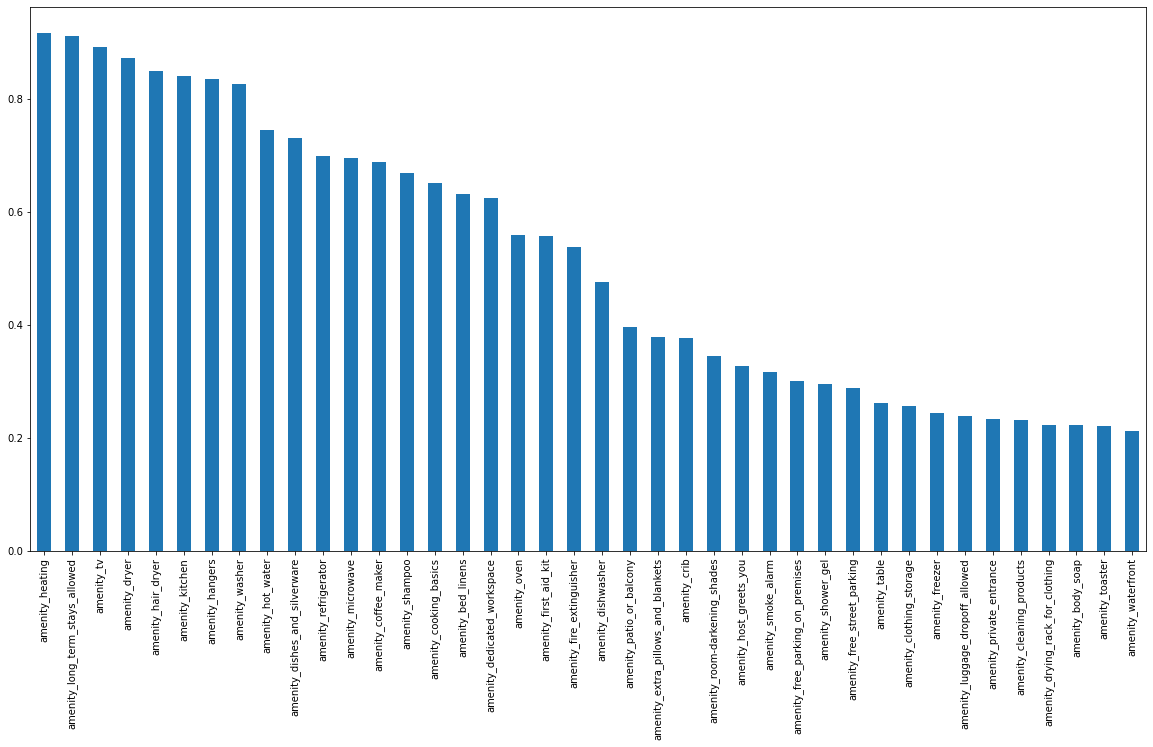

In [1404]:
plt.figure(figsize=(20,10))
(X[amenity_cols].sum()/X.shape[0]).sort_values(ascending=False).iloc[:40].plot(kind='bar')

#### Store Final Dataset

We drop `amenities` text field and check that everything is OK; then, we store the dataset again.

In [1405]:
try:
    X.drop('amenities',axis=1,inplace=True)
except KeyError as err:
    print("Column already removed!")

In [1406]:
X.shape

(3931, 354)

In [1407]:
# There are no categorical columns to be encoded
list(X.select_dtypes(['object']).columns)

[]

In [1408]:
X.describe()

,id,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_location_nearby,has_beach,license_reported,host_since,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bathrooms_private,bathrooms_shared,calculated_host_has_shared_rooms,neighbourhood_group_cleansed_Araba,neighbourhood_group_cleansed_Bizkaia,neighbourhood_group_cleansed_Gipuzkoa,host_response_time_day,host_response_time_few_days,host_response_time_few_hours,host_response_time_hour,description_language_en,description_language_es,description_language_fr,description_language_other,room_type_home,room_type_room_hotel,room_type_room_private,room_type_room_shared,neighbourhood_cleansed_Aia,neighbourhood_cleansed_Amurrio,neighbourhood_cleansed_Asteasu,neighbourhood_cleansed_Astigarraga,neighbourhood_cleansed_Azkoitia,neighbourhood_cleansed_Azpeitia,neighbourhood_cleansed_Bakio,neighbourhood_cleansed_Barakaldo,neighbourhood_cleansed_Bermeo,neighbourhood_cleansed_Bilbao,neighbourhood_cleansed_Busturia,neighbourhood_cleansed_Deba,neighbourhood_cleansed_Derio,neighbourhood_cleansed_Donostia-San_Sebastian,neighbourhood_cleansed_Durango,neighbourhood_cleansed_Ea,neighbourhood_cleansed_Eibar,neighbourhood_cleansed_Elciego,neighbourhood_cleansed_Errenteria,neighbourhood_cleansed_Gautegiz Arteaga,neighbourhood_cleansed_Gernika-Lumo,neighbourhood_cleansed_Getaria,neighbourhood_cleansed_Getxo,neighbourhood_cleansed_Gorliz,neighbourhood_cleansed_Hernani,neighbourhood_cleansed_Hondarribia,neighbourhood_cleansed_Ibarrangelu,neighbourhood_cleansed_Irun,neighbourhood_cleansed_Karrantza Harana,neighbourhood_cleansed_Labastida,neighbourhood_cleansed_Laguardia,neighbourhood_cleansed_Lanciego,neighbourhood_cleansed_Lasarte-Oria,neighbourhood_cleansed_Leioa,neighbourhood_cleansed_Lekeitio,neighbourhood_cleansed_Markina-Xemein,neighbourhood_cleansed_Mendexa,neighbourhood_cleansed_Mundaka,neighbourhood_cleansed_Mungia,neighbourhood_cleansed_Mutriku,neighbourhood_cleansed_Oiartzun,neighbourhood_cleansed_Orio,neighbourhood_cleansed_Ortuella,neighbourhood_cleansed_Pasaia,neighbourhood_cleansed_Plentzia,neighbourhood_cleansed_Portugalete,neighbourhood_cleansed_Samaniego,neighbourhood_cleansed_Santurtzi,neighbourhood_cleansed_Segura,neighbourhood_cleansed_Sestao,neighbourhood_cleansed_Sopelana,neighbourhood_cleansed_Sopuerta,neighbourhood_cleansed_Urduna-Orduna,neighbourhood_cleansed_Urnieta,neighbourhood_cleansed_Valdegovia,neighbourhood_cleansed_Vitoria-Gasteiz,neighbourhood_cleansed_Zarautz,neighbourhood_cleansed_Zuia,neighbourhood_cleansed_Zumaia,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16,property_type_17,property_type_18,property_type_19,property_type_20,property_type_21,property_type_22,property_type_23,property_type_24,property_type_25,property_type_26,property_type_27,property_type_28,property_type_29,property_type_30,property_type_31,property_type_32,property_type_33,property_type_34,property_type_35,property_type_36,property_type_37,property_type_38,property_type_39,property_type_40,property_type_41,property_type_42,property_type_43,property_type_44,property_type_45,property_type_46,property_type_47,property_type_48,property_type_49,prope

In [1409]:
list(X.columns)

['id',
 'bedrooms',
 'beds',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'reviews_per_month',
 'host_total_listings_count',
 'accommodates',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'latitude',
 'longitude',
 'review_scores_average',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews_l30d',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'has_availability',
 'instant_bookable',
 'host_location_nearby',
 'has_beach',
 'license_reported',
 'host_since',
 'first_review',
 'last_review',
 'calculated_host_listings_count_shared_rooms',
 'bathrooms_number',
 'bathrooms_private'

In [1410]:
data = pd.concat([X,y],axis=1)
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean_processed_linear.csv'
data.to_csv(filename, index=False, header=True)

In [159]:
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean_processed_linear.csv'
data = pd.read_csv(filename)
y = data['price']
X = data.drop('price',axis=1)

### 2.5 Polynomial Features

I will compute polynomial features of degree 2 (with interactions) to capture non-linear effects. However, I limit the transformed features tu the numerical ones.

In [160]:
from sklearn.preprocessing import PolynomialFeatures

In [161]:
# Get all predictive features
features = list(X.drop('id',axis=1).columns)

In [162]:
len(features)

353

In [82]:
filepath = './data/euskadi_2022_03_31/'

joblib.dump(features, filepath+'linear_features.joblib')

['./data/euskadi_2022_03_31/linear_features.joblib']

In [52]:
# Detect automatically categorical/binary and continuous/numerical features
# Better than manually taking column names
continuous_features = []
binary_features = []
for f in features:
    if X[f].max() > 1.0 or X[f].min() != 0.0:
        continuous_features.append(f)
    else:
        binary_features.append(f)

In [53]:
# Caandidate features for polynomial features
continuous_features

['bedrooms',
 'beds',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'reviews_per_month',
 'host_total_listings_count',
 'accommodates',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'latitude',
 'longitude',
 'review_scores_average',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews_l30d',
 'host_since',
 'first_review',
 'last_review',
 'calculated_host_listings_count_shared_rooms',
 'bathrooms_number']

In [54]:
X_continuous = X[continuous_features]
X_binary = X[binary_features]

In [55]:
pf = PolynomialFeatures(degree=2, include_bias=False)
features = continuous_features
pf.fit(X_continuous)
feat_array = pf.transform(X_continuous)
X_poly = pd.DataFrame(feat_array, columns = pf.get_feature_names_out(input_features=continuous_features))

In [56]:
X_poly.columns

Index(['bedrooms', 'beds', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'reviews_per_month', 'host_total_listings_count', 'accommodates',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       ...
       'first_review^2', 'first_review last_review',
       'first_review calculated_host_listings_count_shared_rooms',
       'first_review bathrooms_number', 'last_review^2',
       'last_review calculated_host_listings_count_shared_rooms',
       'last_review bathrooms_number',
       'calculated_host_listings_count_shared_rooms^2',
       'calculated_host_listings_count_shared_rooms bathrooms_number',
       'bathrooms_number^2'],
      dtype='object', length=495)

In [57]:
X_new = pd.concat([X['id'],X_poly,X_binary],axis=1)

In [58]:
data = pd.concat([X_new,y],axis=1)
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean_processed_polynomial.csv'
data.to_csv(filename, index=False, header=True)

In [136]:
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean_processed_polynomial.csv'
data = pd.read_csv(filename)
y = data['price']
X = data.drop('price',axis=1)

### 2.6 Scaling

#### Train/Test Split

In [137]:
id_row = X['id']
X_train, X_test, y_train, y_test = train_test_split(
    X.drop('id',axis=1), # predictive variables
    #X, 
    y, # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((3537, 818), (394, 818))

In [138]:
X_train.columns

Index(['bedrooms', 'beds', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'reviews_per_month', 'host_total_listings_count', 'accommodates',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       ...
       'amenity_shower_gel', 'amenity_lake_access',
       'amenity_fenced_garden_or_backyard', 'amenity_barbecue_utensils',
       'amenity_beach_essentials', 'amenity_ev_charger',
       'amenity_private_patio_or_balcony', 'amenity_shared_sauna',
       'amenity_dining_table', 'amenity_extra_pillows_and_blankets'],
      dtype='object', length=818)

#### MinMaxScaler

In [139]:
scaler = MinMaxScaler()

# Fit the scaler to the train set only
scaler.fit(X_train) 

# Transform both train/split and convert the numpy arrays
# into data frames
X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [140]:
X_train

bedrooms      beds  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
0     0.552046  0.351419                0.342305                1.000000   
1     0.000000  0.000000                0.000000                1.000000   
2     0.369770  0.214551                0.049155                1.000000   
3     0.000000  0.000000                0.455314                0.232917   
4     0.000000  0.000000                0.000000                1.000000   
...        ...       ...                     ...                     ...   
3532  0.000000  0.000000                0.511559                1.000000   
3533  0.369770  0.449589                0.384759                1.000000   
3534  0.552046  0.449589                0.342305                0.022660   
3535  0.552046  0.449589                0.523880                0.007214   
3536  0.000000  0.000000                0.000000                1.000000   

      reviews_per_month  host_total_listings_count  accommodates  \
0              0.187315                   0.456470      0.617947   
1              0.424879                   0.000000      0.000000   
2              0.773551                   0.456470      0.461477   
3              0.863030                   0.546721      0.210819   
4              0.317917                   0.456470      0.210819   
...                 ...                        ...           ...   
3532           0.180860                   0.907432      0.210819   
3533           0.678210                   0.577175      0.678220   
3534           0.284065                   0.261421      0.617947   
3535           0.457134                   0.821566      0.547088   
3536           0.218205                   0.000000      0.210819   

      minimum_nights  maximum_nights  minimum_minimum_nights  \
0           0.397105        1.000000                0.420427   
1           0.000000        1.000000                0.000000   
2           0.000000        1.000000                0.000000   
3           0.397105        1.000000                0.000000   
4           0.000000        1.000000                0.000000   
...              ...             ...                     ...   
3532        0.397105        1.000000                0.606446   
3533        0.397105        1.000000                0.420427   
3534        0.397105        0.122045                0.420427   
3535        0.579002        0.060380                0.606446   
3536        0.000000        0.072279                0.000000   

      maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                   0.257167                1.000000                1.000000   
1                   0.000000                1.000000                1.000000   
2                   0.257167                1.000000                1.000000   
3                   0.490132                0.305210                0.221463   
4                   0.000000                1.000000                1.000000   
...                      ...                     ...                     ...   
3532                0.490132                1.000000                1.000000   
3533                0.398860                1.000000                1.000000   
3534                0.257167                0.045479                0.019923   
3535                0.490132                0.017799                0.006125   
3536                0.000000                1.000000                1.000000   

      number_of_reviews  number_of_reviews_ltm  \
0              0.358866               0.317356   
1              0.368983               0.502298   
2              0.648300               0.730258   
3              0.877807               0.680157   
4              0.218980               0.352842   
...                 ...                    ...   
3532           0.348074               0.382773   
3533           0.378504               0.564702   
3534           0.348074               0.317356   
3535           0.000000               0.137585

In [141]:
y_train

706     5.068904
2664    2.995732
2275    5.298317
196     4.077537
2901    3.988984
          ...   
835     4.983607
3264    4.941642
1653    5.978886
2607    5.170484
2732    4.304065
Name: price, Length: 3537, dtype: float64

### 2.7 Persist Final Splits + Additional Data (Scaler, Mappings, etc.)

In [142]:
X_train.shape, y_train.shape

((3537, 818), (3537,))

In [143]:
filepath = './data/euskadi_2022_03_31/'

X_train.to_csv(filepath+'listings_X_train.csv', index=False, header=True)
y_train.to_csv(filepath+'listings_y_train.csv', index=False, header=True)

X_test.to_csv(filepath+'listings_X_test.csv', index=False, header=True)
y_test.to_csv(filepath+'listings_y_test.csv', index=False, header=True)

In [144]:
joblib.dump(scaler, filepath+'minmax_scaler.joblib')

['./data/euskadi_2022_03_31/minmax_scaler.joblib']

In [145]:
property_types = {'index2name':property_type_list,'name2index':property_type_dict}

In [146]:
joblib.dump(property_types, filepath+'property_types.joblib')

['./data/euskadi_2022_03_31/property_types.joblib']

In [147]:
joblib.dump(numerical_transform_params, filepath+'numerical_transform_params.joblib')

['./data/euskadi_2022_03_31/numerical_transform_params.joblib']

In [148]:
y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

## 3. Feature Selection

Since we have many features, we perform a lasso regression for feature selection to detect if there is a better smaller subset of features that would be enough for modelling.

In [149]:
X_train.shape

(3537, 818)

In [150]:
X_train

bedrooms      beds  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
0     0.552046  0.351419                0.342305                1.000000   
1     0.000000  0.000000                0.000000                1.000000   
2     0.369770  0.214551                0.049155                1.000000   
3     0.000000  0.000000                0.455314                0.232917   
4     0.000000  0.000000                0.000000                1.000000   
...        ...       ...                     ...                     ...   
3532  0.000000  0.000000                0.511559                1.000000   
3533  0.369770  0.449589                0.384759                1.000000   
3534  0.552046  0.449589                0.342305                0.022660   
3535  0.552046  0.449589                0.523880                0.007214   
3536  0.000000  0.000000                0.000000                1.000000   

      reviews_per_month  host_total_listings_count  accommodates  \
0              0.187315                   0.456470      0.617947   
1              0.424879                   0.000000      0.000000   
2              0.773551                   0.456470      0.461477   
3              0.863030                   0.546721      0.210819   
4              0.317917                   0.456470      0.210819   
...                 ...                        ...           ...   
3532           0.180860                   0.907432      0.210819   
3533           0.678210                   0.577175      0.678220   
3534           0.284065                   0.261421      0.617947   
3535           0.457134                   0.821566      0.547088   
3536           0.218205                   0.000000      0.210819   

      minimum_nights  maximum_nights  minimum_minimum_nights  \
0           0.397105        1.000000                0.420427   
1           0.000000        1.000000                0.000000   
2           0.000000        1.000000                0.000000   
3           0.397105        1.000000                0.000000   
4           0.000000        1.000000                0.000000   
...              ...             ...                     ...   
3532        0.397105        1.000000                0.606446   
3533        0.397105        1.000000                0.420427   
3534        0.397105        0.122045                0.420427   
3535        0.579002        0.060380                0.606446   
3536        0.000000        0.072279                0.000000   

      maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                   0.257167                1.000000                1.000000   
1                   0.000000                1.000000                1.000000   
2                   0.257167                1.000000                1.000000   
3                   0.490132                0.305210                0.221463   
4                   0.000000                1.000000                1.000000   
...                      ...                     ...                     ...   
3532                0.490132                1.000000                1.000000   
3533                0.398860                1.000000                1.000000   
3534                0.257167                0.045479                0.019923   
3535                0.490132                0.017799                0.006125   
3536                0.000000                1.000000                1.000000   

      number_of_reviews  number_of_reviews_ltm  \
0              0.358866               0.317356   
1              0.368983               0.502298   
2              0.648300               0.730258   
3              0.877807               0.680157   
4              0.218980               0.352842   
...                 ...                    ...   
3532           0.348074               0.382773   
3533           0.378504               0.564702   
3534           0.348074               0.317356   
3535           0.000000               0.137585

In [151]:
# We will do the model fitting and feature selection

# First, we specify the Lasso Regression model, and we
# select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then we use the SelectFromModel object from sklearn, which
# will select automatically the features which coefficients are non-zero

# Set and save the seed for reproducibility

# We cross validation to choose the optimum alpha = regularization strength
alphas = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
model = LassoCV(alphas=alphas,
                max_iter=5e5,
                cv=4,
                random_state=0)
# Train/Fit auxiliary Lasso model
model.fit(X_train, y_train)
# Run the feature selection
sel_ = SelectFromModel(Lasso(alpha=model.alpha_, random_state=0))

# Train Lasso model and select features
sel_.fit(X_train, y_train)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1724655287080452, tolerance: 0.12426326587884048
  positive,
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21786766911145605, tolerance: 0.12653040664146656
  positive,
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: Con

SelectFromModel(estimator=Lasso(alpha=0.0001, random_state=0))

In [152]:
model.alpha_

0.0001

In [153]:
# Get the selected variables
sel_.get_support().sum()

443

In [154]:
sel_.get_support()

array([ True, False,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False,  True, False,  True, False, False,  True,
        True, False, False, False, False, False, False,  True, False,
        True, False,  True, False, False, False,  True, False, False,
        True,  True,  True,  True, False,  True, False, False,  True,
       False,  True, False, False, False, False,  True, False,  True,
       False,  True, False, False,  True, False, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
        True, False,  True, False, False,  True,  True, False, False,
        True, False, False, False,  True, False,  True,  True, False,
        True, False,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True, False, False, False,  True, False, False,
       False, False,

In [155]:
# List of selected features
selected_features = list(X_train.columns[(sel_.get_support())])

print(f'Total features: {X_train.shape[1]}')
print(f'Selected features: {len(selected_features)}')
print(f'Features with coefficients that converged to 0 (not selected): {np.sum(sel_.estimator_.coef_ == 0)}')

Total features: 818
Selected features: 443
Features with coefficients that converged to 0 (not selected): 375


In [156]:
# Srint the selected features
selected_features

['bedrooms',
 'minimum_nights_avg_ntm',
 'reviews_per_month',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'number_of_reviews',
 'availability_60',
 'availability_365',
 'first_review',
 'last_review',
 'bedrooms reviews_per_month',
 'bedrooms accommodates',
 'bedrooms maximum_nights',
 'bedrooms maximum_maximum_nights',
 'bedrooms calculated_host_listings_count',
 'bedrooms calculated_host_listings_count_entire_homes',
 'bedrooms latitude',
 'bedrooms longitude',
 'bedrooms availability_30',
 'bedrooms availability_365',
 'bedrooms host_since',
 'beds^2',
 'beds maximum_nights_avg_ntm',
 'beds host_total_listings_count',
 'beds maximum_nights',
 'beds maximum_maximum_nights',
 'beds number_of_reviews',
 'beds number_of_reviews_ltm',
 'beds calculated_host_listings_count_entire_homes',
 'beds availability_90',
 'beds number_of_reviews_l30d',
 'beds last_review',
 'beds calculated_host_listings_count_shar

#### Persist the List of Selected Features

In [158]:
filepath = './data/euskadi_2022_03_31/'

joblib.dump(selected_features, filepath+'selected_features.joblib')

['./data/euskadi_2022_03_31/selected_features.joblib']